# **Alzheimer MRI Disease Classification**

In [ ]:
!pip install datasets


## **LeNet**

Epoch [1/15] - Train Loss: 1.0627, Train Acc: 0.4781, Test Loss: 1.0174, Test Acc: 0.4953
Epoch [2/15] - Train Loss: 1.0027, Train Acc: 0.5111, Test Loss: 0.9794, Test Acc: 0.5344
Epoch [3/15] - Train Loss: 0.9429, Train Acc: 0.5518, Test Loss: 0.9385, Test Acc: 0.5648
Epoch [4/15] - Train Loss: 0.9099, Train Acc: 0.5668, Test Loss: 0.8969, Test Acc: 0.5703
Epoch [5/15] - Train Loss: 0.8733, Train Acc: 0.5816, Test Loss: 0.8877, Test Acc: 0.5586
Epoch [6/15] - Train Loss: 0.8492, Train Acc: 0.5973, Test Loss: 0.8601, Test Acc: 0.6062
Epoch [7/15] - Train Loss: 0.7942, Train Acc: 0.6328, Test Loss: 0.7505, Test Acc: 0.6602
Epoch [8/15] - Train Loss: 0.7068, Train Acc: 0.6799, Test Loss: 0.6828, Test Acc: 0.6922
Epoch [9/15] - Train Loss: 0.5817, Train Acc: 0.7533, Test Loss: 0.5354, Test Acc: 0.7906
Epoch [10/15] - Train Loss: 0.4049, Train Acc: 0.8410, Test Loss: 0.4538, Test Acc: 0.8164
Epoch [11/15] - Train Loss: 0.2261, Train Acc: 0.9158, Test Loss: 0.3729, Test Acc: 0.8617
Epoch [1

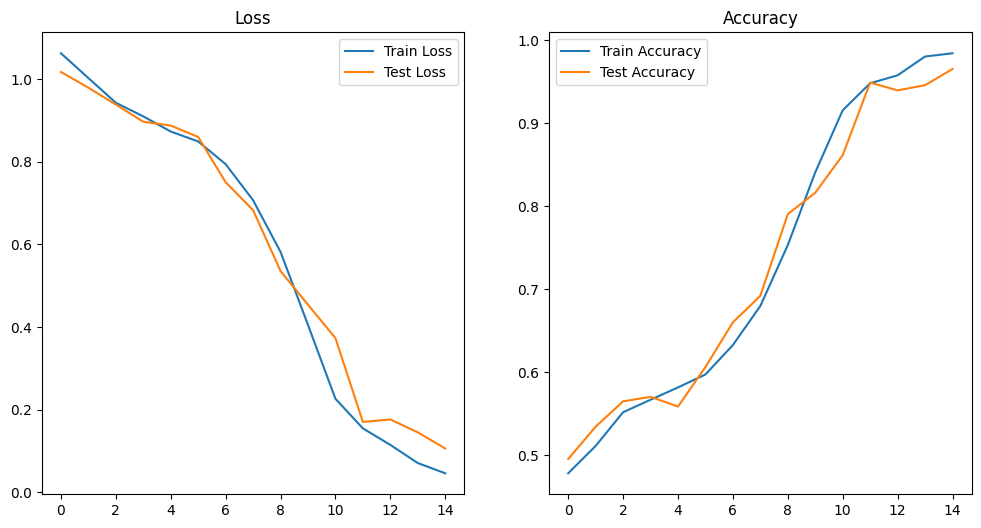

F1-Score: 0.9658, Accuracy: 0.9656


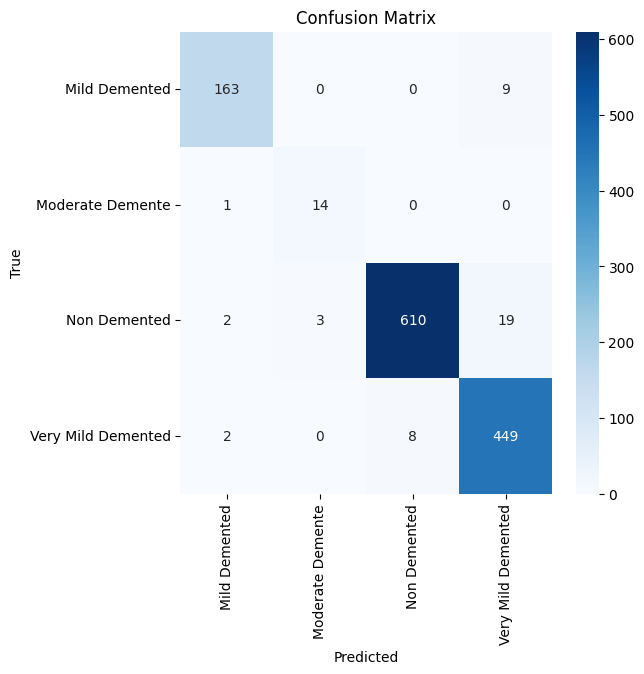

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# 1. Load Dataset
train_dataset = load_dataset('Falah/Alzheimer_MRI', split='train')
test_dataset = load_dataset('Falah/Alzheimer_MRI', split='test')

# 2. Define Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128
    transforms.ToTensor(),          # Convert to PyTorch Tensor
])

# 3. Define PyTorch Dataset
class AlzheimerMRIDataset(Dataset):
    def __init__(self, dataset, num_classes, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.num_classes = num_classes  # Number of classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Access row
        item = self.dataset[idx]
        # Load image
        image = item['image']  # Should be PIL Image or JpegImageFile
        # Apply transformation if defined
        if self.transform:
            image = self.transform(image)
        # Load label
        label = item['label']

        return image, label

# 4. Determine Number of Classes
# Assuming the labels are integers starting from 0 to the number of classes-1
num_classes = len(set(item['label'] for item in train_dataset))  # Get unique classes

# 5. Create PyTorch Dataset
train_dataset = AlzheimerMRIDataset(train_dataset, num_classes=num_classes, transform=transform)
test_dataset = AlzheimerMRIDataset(test_dataset, num_classes=num_classes, transform=transform)

# 6. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

input_shape = train_dataset[0][0].shape
output_shape = train_dataset.num_classes


## model definition

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.fe = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5,5), stride=1, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), stride=1, padding=2),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=(2,2), stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1, padding=1),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=(2,2), stride=2, padding=0)
        )

        self.flatten = nn.Flatten()

        self.fcs = nn.Sequential(
            nn.Linear(64*32*32,1024),
            nn.LeakyReLU(),
            nn.Linear(1024,512),
            nn.LeakyReLU(),
            nn.Linear(512,256),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(256, output_shape)
        )


    def forward(self,x):

        hidden = self.fe(x)
        hidden = self.flatten(hidden)
        output = self.fcs(hidden)

        return output


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LeNet().to(device)
loss_function = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-3)


num_epochs = 15
train_loss_list, test_loss_list = [], []
train_acc_list, test_acc_list = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct_train, total_train = 0, 0, 0

    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        # Forward pass
        y_pred = model(x)

        # Calculate loss
        loss = loss_function(y_pred, y)
        total_loss += loss.item() * x.size(0)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, preds = torch.max(y_pred, 1)
        correct_train += torch.sum(preds == y).item()
        total_train += y.size(0)

    # Compute average loss and accuracy
    avg_train_loss = total_loss / total_train
    train_accuracy = correct_train / total_train
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)

    # Evaluation on the test set
    model.eval()
    total_loss, correct_test, total_test = 0, 0, 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            # Calculate loss
            loss = loss_function(y_pred, y)
            total_loss += loss.item() * x.size(0)

            # Calculate accuracy
            _, preds = torch.max(y_pred, 1)
            correct_test += torch.sum(preds == y).item()
            total_test += y.size(0)

    avg_test_loss = total_loss / total_test
    test_accuracy = correct_test / total_test
    test_loss_list.append(avg_test_loss)
    test_acc_list.append(test_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")



# 11. Plot Training and Test Loss/Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

# 12. Calculate F1-Score and Confusion Matrix
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_true.extend(y.cpu().numpy())
        outputs = model(x)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())

# F1-Score and Accuracy
f1 = f1_score(y_true, y_pred, average='weighted')
acc = accuracy_score(y_true, y_pred)
print(f"F1-Score: {f1:.4f}, Accuracy: {acc:.4f}")

# Confusion Matrix
label_names = ["Mild Demented", "Moderate Demente", "Non Demented", "Very Mild Demented"]

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()